In [290]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
import astropy.constants as const
from scipy.optimize import minimize
import emcee
import corner
from multiprocessing import Pool

from sn_companion_collision.sn_collision import kasen, get_filter_trans

In [2]:
%matplotlib notebook

In [3]:
# get obs
uvot_df = pd.read_csv('../data/phot/UVOT_hostsub.ascii',
                      delim_whitespace=True)
uvot_df.head()

,MJD,ISOT,FILTER,AB_FNU_mJy,AB_FNU_mJy_ERRM,AB_FNU_mJy_ERRP
0,58846.9019,2019-12-29T21:38:46.407,UVW2,0.314516,0.022726,0.023071
1,58846.9657,2019-12-29T23:10:36.241,UVW2,0.308226,0.022491,0.022268
2,58848.7636,2019-12-31T18:19:36.731,UVW2,0.055253,0.007696,0.007967
3,58848.9693,2019-12-31T23:15:47.658,UVW2,0.048824,0.007868,0.007814
4,58849.5536,2020-01-01T13:17:08.689,UVW2,0.044916,0.005618,0.005607


In [221]:
# get optical obs
p48_df = pd.read_csv('../plots/flux_p48.csv')

g_obs = np.where(p48_df['filt'] == "b'g'")
r_obs = np.where(p48_df.filt == "b'r'")
i_obs = np.where(p48_df.filt == "b'i'")

p48_df.head()

,mjd,flux,flux_unc,filt
0,58846.469942,0.000505,0.000007,b'r'
1,58846.538530,0.000374,0.000005,b'i'
2,58846.558252,0.000595,0.000006,b'g'
3,58849.448924,0.000488,0.000008,b'r'
4,58849.507824,0.000379,0.000006,b'g'


In [222]:
# metadata
z = 0.0094
mu = 33.14
MW_ebv = 0.018
NGC_ebv = 0.39/0.22*MW_ebv
tbmax = 58863.34
t_fl = -17.4928

In [223]:
uvm2 = get_filter_trans.get_uvm2_tc()
uvw1 = get_filter_trans.get_uvw1_tc()
uvw2 = get_filter_trans.get_uvw2_tc()

g = get_filter_trans.get_g_ztf_tc()
r = get_filter_trans.get_r_ztf_tc()
i = get_filter_trans.get_i_ztf_tc()

/Users/adamamiller/software/aam_python/sn_companion_collision/sn_collision/kasen.py:93: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  self.wavelength.max())[0]
/Users/adamamiller/software/aam_python/sn_companion_collision/sn_collision/kasen.py:101: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting

In [225]:
theta = 0

t_grid = np.linspace(.01,10,250)
a_grid = np.array([1.5e12, 2e12, 2.5e12, 2.7e12])
m_g_ptf = np.ndarray((len(t_grid), len(a_grid)))
m_uvm2 = np.ndarray((len(t_grid), len(a_grid)))
m_uvw1 = np.ndarray((len(t_grid), len(a_grid)))
m_uvw2 = np.ndarray((len(t_grid), len(a_grid)))

m_g = np.ndarray((len(t_grid), len(a_grid)))
m_r = np.ndarray((len(t_grid), len(a_grid)))
m_i = np.ndarray((len(t_grid), len(a_grid)))

for a in a_grid:
    for t in t_grid:
        model = kasen.SNCompanionCollision(a=a, M=1.0*const.M_sun.cgs.value, v=2e9)
        mag_uvm2 = kasen.ObservedFlux(model, theta, uvm2, 
                                      t = t, redshift=z, mu=mu, 
                                      local_EBV=NGC_ebv, 
                                      galactic_EBV=MW_ebv, return_mag=True)
        mag_uvw1 = kasen.ObservedFlux(model, theta, uvw1, 
                                      t = t, redshift=z, mu=mu, 
                                      local_EBV=NGC_ebv, 
                                      galactic_EBV=MW_ebv, return_mag=True)
        mag_uvw2 = kasen.ObservedFlux(model, theta, uvw2, 
                                      t = t, redshift=z, mu=mu, 
                                      local_EBV=NGC_ebv, 
                                      galactic_EBV=MW_ebv, return_mag=True)
        mag_g = kasen.ObservedFlux(model, theta, g, 
                                   t = t, redshift=z, mu=mu, 
                                   local_EBV=NGC_ebv, 
                                   galactic_EBV=MW_ebv, return_mag=True)
        mag_r = kasen.ObservedFlux(model, theta, r, 
                                   t = t, redshift=z, mu=mu, 
                                   local_EBV=NGC_ebv, 
                                   galactic_EBV=MW_ebv, return_mag=True)
        mag_i = kasen.ObservedFlux(model, theta, i, 
                                   t = t, redshift=z, mu=mu, 
                                   local_EBV=NGC_ebv, 
                                   galactic_EBV=MW_ebv, return_mag=True)
        
        m_uvm2[t_grid == t, a_grid == a] = mag_uvm2
        m_uvw1[t_grid == t, a_grid == a] = mag_uvw1
        m_uvw2[t_grid == t, a_grid == a] = mag_uvw2
        m_g[t_grid == t, a_grid == a] = mag_g
        m_r[t_grid == t, a_grid == a] = mag_r
        m_i[t_grid == t, a_grid == a] = mag_i

<IPython.core.display.Javascript object>


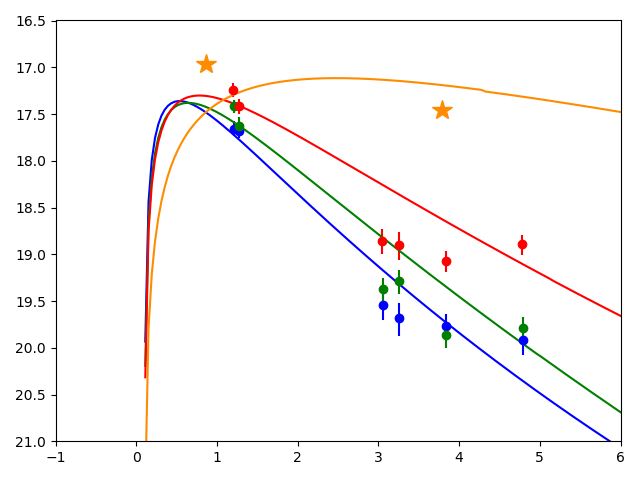

In [229]:
t_offset = 0.1
flux_offset = 1/3
mag_offset = -2.5*np.log10(flux_offset)

fig, ax = plt.subplots()
ax.plot(t_grid + t_offset, m_uvw2[:,1] + mag_offset, 'blue')
ax.plot(t_grid + t_offset, m_uvm2[:,1] + mag_offset, 'green')
ax.plot(t_grid + t_offset, m_uvw1[:,1] + mag_offset, 'red')

# ax.plot(t_grid + t_offset, m_uvw2[:,2], 'blue', ls='--')
# ax.plot(t_grid + t_offset, m_uvm2[:,2], 'green', ls='--')
# ax.plot(t_grid + t_offset, m_uvw1[:,2], 'red', ls='--')

ax.plot(t_grid + t_offset, m_g[:,1] + mag_offset, 'DarkOrange')
# ax.plot(t_grid + t_offset, m_g[:,2], 'DarkOrange', ls='--')


ax.plot((p48_df.mjd.iloc[g_obs].values[0] - tbmax)/(1+z) - t_fl, 
        -2.5*np.log10(p48_df.flux.iloc[g_obs].values[0]/3631), 
        '*', c='DarkOrange', ms=15)
ax.plot((p48_df.mjd.iloc[g_obs].values[1] - tbmax)/(1+z) - t_fl, 
        -2.5*np.log10(p48_df.flux.iloc[g_obs].values[1]/3631), 
        '*', c='DarkOrange', ms=15)

uvm2_obs = np.where(uvot_df['FILTER'] == 'UVM2')
uvm2_time = (uvot_df.iloc[uvm2_obs].MJD.values - tbmax)/(1+z)-t_fl
uvm2_mag = -2.5*np.log10(uvot_df.iloc[uvm2_obs].AB_FNU_mJy/3.631e6)
plus_mag = uvm2_mag + 2.5*np.log10((uvot_df.iloc[uvm2_obs].AB_FNU_mJy + 
                                   uvot_df.iloc[uvm2_obs].AB_FNU_mJy_ERRP)/3.631e6)
minus_mag = -uvm2_mag - 2.5*np.log10((uvot_df.iloc[uvm2_obs].AB_FNU_mJy - 
                                   uvot_df.iloc[uvm2_obs].AB_FNU_mJy_ERRM)/3.631e6)
uvm2_mag_unc = np.vstack([plus_mag.values, minus_mag.values])



uvw1_obs = np.where(uvot_df['FILTER'] == 'UVW1')
uvw1_time = (uvot_df.iloc[uvw1_obs].MJD.values - tbmax)/(1+z)-t_fl
uvw1_mag = -2.5*np.log10(uvot_df.iloc[uvw1_obs].AB_FNU_mJy/3.631e6)
plus_mag = uvw1_mag + 2.5*np.log10((uvot_df.iloc[uvw1_obs].AB_FNU_mJy + 
                                   uvot_df.iloc[uvw1_obs].AB_FNU_mJy_ERRP)/3.631e6)
minus_mag = -uvw1_mag - 2.5*np.log10((uvot_df.iloc[uvw1_obs].AB_FNU_mJy - 
                                   uvot_df.iloc[uvw1_obs].AB_FNU_mJy_ERRM)/3.631e6)
uvw1_mag_unc = np.vstack([plus_mag.values, minus_mag.values])


uvw2_obs = np.where(uvot_df['FILTER'] == 'UVW2')
uvw2_time = (uvot_df.iloc[uvw2_obs].MJD.values - tbmax)/(1+z)-t_fl
uvw2_mag = -2.5*np.log10(uvot_df.iloc[uvw2_obs].AB_FNU_mJy/3.631e6)
plus_mag = uvw2_mag + 2.5*np.log10((uvot_df.iloc[uvw2_obs].AB_FNU_mJy + 
                                   uvot_df.iloc[uvw2_obs].AB_FNU_mJy_ERRP)/3.631e6)
minus_mag = -uvw2_mag - 2.5*np.log10((uvot_df.iloc[uvw2_obs].AB_FNU_mJy - 
                                   uvot_df.iloc[uvw2_obs].AB_FNU_mJy_ERRM)/3.631e6)
uvw2_mag_unc = np.vstack([plus_mag.values, minus_mag.values])



ax.errorbar(uvw2_time, uvw2_mag, uvw2_mag_unc,
            fmt = 'o', color='blue')
ax.errorbar(uvm2_time, uvm2_mag, uvm2_mag_unc,
            fmt = 'o', color='green')
ax.errorbar(uvw1_time, uvw1_mag, uvw1_mag_unc,
            fmt = 'o', color='red')

ax.set_ylim(21,16.5)
ax.set_xlim(-1,6)

fig.tight_layout()

## Theta = 60 deg

In [230]:
theta = 60

t_grid = np.linspace(.01,10,250)
a_grid = np.array([2e12, 2.5e12, 3e12, 4e12])
m_g_ptf = np.ndarray((len(t_grid), len(a_grid)))
m_uvm2 = np.ndarray((len(t_grid), len(a_grid)))
m_uvw1 = np.ndarray((len(t_grid), len(a_grid)))
m_uvw2 = np.ndarray((len(t_grid), len(a_grid)))

m_g = np.ndarray((len(t_grid), len(a_grid)))

for a in a_grid:
    for t in t_grid:
        model = kasen.SNCompanionCollision(a=a, M=1.4*const.M_sun.cgs.value)
        mag_uvm2 = kasen.ObservedFlux(model, theta, uvm2, 
                                      t = t, redshift=z, mu=mu, 
                                      local_EBV=NGC_ebv, 
                                      galactic_EBV=MW_ebv, return_mag=True)
        mag_uvw1 = kasen.ObservedFlux(model, theta, uvw1, 
                                      t = t, redshift=z, mu=mu, 
                                      local_EBV=NGC_ebv, 
                                      galactic_EBV=MW_ebv, return_mag=True)
        mag_uvw2 = kasen.ObservedFlux(model, theta, uvw2, 
                                      t = t, redshift=z, mu=mu, 
                                      local_EBV=NGC_ebv, 
                                      galactic_EBV=MW_ebv, return_mag=True)
        mag_g = kasen.ObservedFlux(model, theta, g, 
                                   t = t, redshift=z, mu=mu, 
                                   local_EBV=NGC_ebv, 
                                   galactic_EBV=MW_ebv, return_mag=True)
        
        m_uvm2[t_grid == t, a_grid == a] = mag_uvm2
        m_uvw1[t_grid == t, a_grid == a] = mag_uvw1
        m_uvw2[t_grid == t, a_grid == a] = mag_uvw2
        m_g[t_grid == t, a_grid == a] = mag_g

<IPython.core.display.Javascript object>


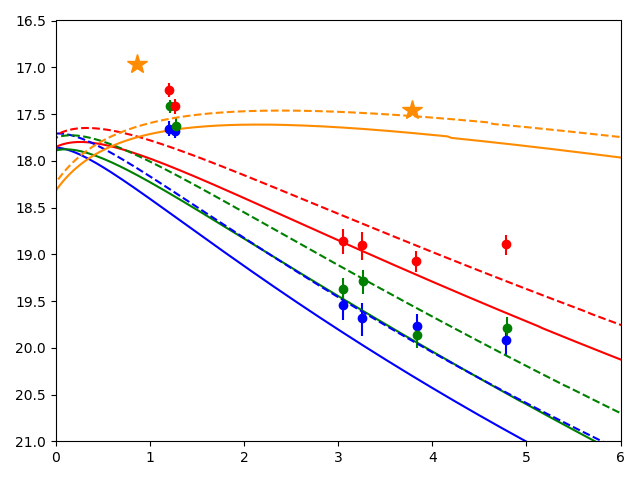

In [231]:
model_offset = -0.5

fig, ax = plt.subplots()
ax.plot(t_grid + model_offset, m_uvw2[:,1], 'blue')
ax.plot(t_grid + model_offset, m_uvm2[:,1], 'green')
ax.plot(t_grid + model_offset, m_uvw1[:,1], 'red')

ax.plot(t_grid + model_offset, m_uvw2[:,2], 'blue', ls='--')
ax.plot(t_grid + model_offset, m_uvm2[:,2], 'green', ls='--')
ax.plot(t_grid + model_offset, m_uvw1[:,2], 'red', ls='--')


ax.plot((p48_df.mjd.iloc[g_obs].values[0] - tbmax)/(1+z) - t_fl, 
        -2.5*np.log10(p48_df.flux.iloc[g_obs].values[0]/3631), 
        '*', c='DarkOrange', ms=15)
ax.plot((p48_df.mjd.iloc[g_obs].values[1] - tbmax)/(1+z) - t_fl, 
        -2.5*np.log10(p48_df.flux.iloc[g_obs].values[1]/3631), 
        '*', c='DarkOrange', ms=15)

ax.plot(t_grid + model_offset, m_g[:,1], 'DarkOrange')
ax.plot(t_grid + model_offset, m_g[:,2], 'DarkOrange', ls='--')

uvm2_obs = np.where(uvot_df['FILTER'] == 'UVM2')
uvm2_time = (uvot_df.iloc[uvm2_obs].MJD.values - tbmax)/(1+z)-t_fl
uvm2_mag = -2.5*np.log10(uvot_df.iloc[uvm2_obs].AB_FNU_mJy/3.631e6)
plus_mag = uvm2_mag + 2.5*np.log10((uvot_df.iloc[uvm2_obs].AB_FNU_mJy + 
                                   uvot_df.iloc[uvm2_obs].AB_FNU_mJy_ERRP)/3.631e6)
minus_mag = -uvm2_mag - 2.5*np.log10((uvot_df.iloc[uvm2_obs].AB_FNU_mJy - 
                                   uvot_df.iloc[uvm2_obs].AB_FNU_mJy_ERRM)/3.631e6)
uvm2_mag_unc = np.vstack([plus_mag.values, minus_mag.values])



uvw1_obs = np.where(uvot_df['FILTER'] == 'UVW1')
uvw1_time = (uvot_df.iloc[uvw1_obs].MJD.values - tbmax)/(1+z)-t_fl
uvw1_mag = -2.5*np.log10(uvot_df.iloc[uvw1_obs].AB_FNU_mJy/3.631e6)
plus_mag = uvw1_mag + 2.5*np.log10((uvot_df.iloc[uvw1_obs].AB_FNU_mJy + 
                                   uvot_df.iloc[uvw1_obs].AB_FNU_mJy_ERRP)/3.631e6)
minus_mag = -uvw1_mag - 2.5*np.log10((uvot_df.iloc[uvw1_obs].AB_FNU_mJy - 
                                   uvot_df.iloc[uvw1_obs].AB_FNU_mJy_ERRM)/3.631e6)
uvw1_mag_unc = np.vstack([plus_mag.values, minus_mag.values])


uvw2_obs = np.where(uvot_df['FILTER'] == 'UVW2')
uvw2_time = (uvot_df.iloc[uvw2_obs].MJD.values - tbmax)/(1+z)-t_fl
uvw2_mag = -2.5*np.log10(uvot_df.iloc[uvw2_obs].AB_FNU_mJy/3.631e6)
plus_mag = uvw2_mag + 2.5*np.log10((uvot_df.iloc[uvw2_obs].AB_FNU_mJy + 
                                   uvot_df.iloc[uvw2_obs].AB_FNU_mJy_ERRP)/3.631e6)
minus_mag = -uvw2_mag - 2.5*np.log10((uvot_df.iloc[uvw2_obs].AB_FNU_mJy - 
                                   uvot_df.iloc[uvw2_obs].AB_FNU_mJy_ERRM)/3.631e6)
uvw2_mag_unc = np.vstack([plus_mag.values, minus_mag.values])



ax.errorbar(uvw2_time, uvw2_mag, uvw2_mag_unc,
            fmt = 'o', color='blue')
ax.errorbar(uvm2_time, uvm2_mag, uvm2_mag_unc,
            fmt = 'o', color='green')
ax.errorbar(uvw1_time, uvw1_mag, uvw1_mag_unc,
            fmt = 'o', color='red')

ax.set_ylim(21,16.5)
ax.set_xlim(0,6)

fig.tight_layout()

## Likelihood model

Assume a Gaussian likelihood model, in order to calculate what model parameters are the optimal.

In [237]:
def lnlike_companion_collision(theta, 
                               t_rf, flux, flux_unc, filt,
                               redshift=0, mu=0, 
                               local_EBV=0, MW_EBV=0):
    '''
    Calculate the log-likelihood of the data given interaction parameters
    
    
    Parameters
    ----------
    theta : tuple of shape (5,)
        model parameters for the Kasen (2010) interation model.
        In order -- 
        a : companion separation in cm
        m_ej : ejecta mass in m_sun 
        v_ej : ejecta velocity in cm/s
        th_companion : viewing angle for position of companion
        t_exp : time of explosion
    
    t_rf : array-like of shape (n_obs,)
        Rest-frame time of observations
    
    flux : array-like of shape (n_obs,)
        Observed flux values in Jy
    
    flux_unc : array-like of shape (n_obs,)
        Observed flux uncertainties in Jy

    filt : array-like of shape (n_obs,)
        Passband of the observations
    
    redshift : float, optional (default=0)
        Redshift of the SN
    
    mu : float, optional (default=0)
        distance modulus to the SN
    
    local_EBV : float, optional (default=0)
        E(B-V) in the SN host galaxy
        
    MW_EBV : float, optional (default=0)
        E(B-V) in the Milky Way along the line of sight 
        to the SN

    Returns
    -------
    lnlike : float
        log-likelihood of the model
    
    '''
    lna, m_ej, lnv_ej, th_companion, t_exp = theta
    a = np.exp(lna)
    v_ej = np.exp(lnv_ej)
    model = kasen.SNCompanionCollision(a=a, 
                                       M=m_ej*const.M_sun.cgs.value, 
                                       v=v_ej)
    
    model_fluxes = np.ones_like(flux)*np.inf
    for obs_num, (mf, t, fltr)  in enumerate(zip(model_fluxes, t_rf, filt)):
        model_fluxes[obs_num] = kasen.ObservedFlux(model, th_companion, fltr, 
                                                   t = t+t_exp, redshift=redshift, mu=mu, 
                                                   local_EBV=local_EBV, 
                                                   galactic_EBV=MW_ebv)

    lnlike = -0.5*np.sum((flux - model_fluxes)**2/flux_unc**2)
    
    return lnlike

def lnprior_companion_collision(theta):
    '''
    Calculate the log-prior of the model parameters
    
    
    Parameters
    ----------
    theta : tuple of shape (4,)
        model parameters for the Kasen (2010) interation model.
        In order -- 
        a : companion separation in cm
        m_ej : ejecta mass in m_sun 
        v_ej : ejecta velocity in cm/s
        th_companion : viewing angle for position of companion
        t_exp : time of explosion

    Returns
    -------
    lnprior : float
        log-prior of the model
    
    '''
    lna, m_ej, lnv_ej, th_companion, t_exp = theta
    a = np.exp(lna)
    v_ej = np.exp(lnv_ej)

    if (1e10 < a < 1e13 and 
        0.6 < m_ej < 1.5 and
        5e8 < v_ej < 3e9 and 
        0 < th_companion < 180 and 
        0 < t_exp < 5):
        lnprior = 0.0
    else:
        lnprior = -np.inf
    return lnprior

def lnposterior(theta, 
                t_rf, flux, flux_unc, filt,
                redshift=0, mu=0, 
                local_EBV=0, MW_EBV=0):
    lnp = lnprior_companion_collision(theta)
    lnl = lnlike_companion_collision(theta, 
                t_rf, flux, flux_unc, filt,
                redshift, mu, 
                local_EBV, MW_EBV)
    if not np.isfinite(lnp):
        return -np.inf
    return lnl + lnp

In [238]:
## massage data
uv_include = np.where(uvot_df.MJD.values < 58849.2)

In [239]:
t_rf = (uvot_df.MJD.iloc[uv_include].values - p48_df.mjd.values[0])/(1+z)
flux = uvot_df.AB_FNU_mJy.iloc[uv_include].values*1e-3
flux_unc = np.average(np.vstack((uvot_df.AB_FNU_mJy_ERRM.iloc[uv_include].values, 
                                 uvot_df.AB_FNU_mJy_ERRP.iloc[uv_include].values)),axis=0)*1e-3
filt = []
filt_dict = {'UVW2':uvw2, 'UVM2':uvm2, 'UVW1':uvw1}
for fltr in uvot_df.FILTER.iloc[uv_include].values:
    filt.append(filt_dict[fltr])

In [240]:
# add single g-band obs
t_rf = np.append(t_rf, (p48_df.mjd.values[2] - p48_df.mjd.values[0])/(1+z))
flux = np.append(flux, p48_df.flux.values[2])
flux_unc = np.append(flux_unc, p48_df.flux_unc.values[2])
filt.append(g)


# add single r-band obs
t_rf = np.append(t_rf, 0)
flux = np.append(flux, p48_df.flux.values[0])
flux_unc = np.append(flux_unc, p48_df.flux.values[0])
filt.append(r)

# add single i-band obs
t_rf = np.append(t_rf, (p48_df.mjd.values[1] - p48_df.mjd.values[0])/(1+z))
flux = np.append(flux, p48_df.flux.values[1])
flux_unc = np.append(flux_unc, p48_df.flux_unc.values[1])
filt.append(i)

In [241]:
%%timeit
lnlike_companion_collision((27.3, 1.4, 20.7, 0, 1),
                           t_rf, flux, flux_unc, filt,
                           redshift=z, mu=mu,
                           local_EBV=NGC_ebv, 
                           MW_EBV=MW_ebv)

91.8 ms ± 6.52 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [410]:
nwalkers = 30
ndim=5
nfac=1e-2
guess_0 = (27.5,  1.0, 21.7, 50,  0.9)

#initial position of walkers
rand_pos = [1 + nfac*np.random.randn(ndim) for i in range(nwalkers)]
pos = np.array(guess_0)*rand_pos

with Pool() as pool:

    sampler = emcee.EnsembleSampler(nwalkers, ndim, 
                                    lnposterior, 
                                    args=(t_rf, flux, flux_unc, filt,
                                          z, mu, 
                                          NGC_ebv, 
                                          MW_ebv),
                                    pool=pool)
    
    max_samples = 1500

    old_tau = np.inf
    for sample in sampler.sample(pos, 
                                 iterations=max_samples, 
                                 progress=True):
        if  sampler.iteration % int(1e3):
            continue
        tau = sampler.get_autocorr_time(tol=0)
        # Check convergence
        converged = np.all(tau * 100 < sampler.iteration)
        converged &= np.all(np.abs(old_tau - tau) / tau < 0.01)
        if converged:
            break
        old_tau = tau

  0%|          | 0/1500 [00:00<?, ?it/s]/Users/adamamiller/miniconda3/envs/emcee3/lib/python3.7/site-packages/emcee-3.0rc2-py3.7.egg/emcee/moves/red_blue.py:97: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]
 10%|▉         | 148/1500 [02:23<24:31,  1.09s/it]/Users/adamamiller/software/aam_python/sn_companion_collision/sn_collision/kasen.py:48: RuntimeWarning: invalid value encountered in double_scalars
  luminosity = 1e43 * self.a * self.M**(0.25) * self.v**(1.75) * self.kappa**(-0.75) * t**(-0.5)
/Users/adamamiller/software/aam_python/sn_companion_collision/sn_collision/kasen.py:131: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  return integrate.quad(func, self.wavelength.min(), self.wavelength.max())[0]
 12%|█▏        | 187/1500 [03:06<21:15,  1.03it/s]/Users/adamamiller/software/aam_python/sn_companion_collisio

In [411]:
tau = sampler.get_autocorr_time(tol=0)
burnin = 4*int(max(tau))
print(tau)

[ 74.42000026 103.96737594 112.17537935 119.34452338  76.13210133]


<IPython.core.display.Javascript object>


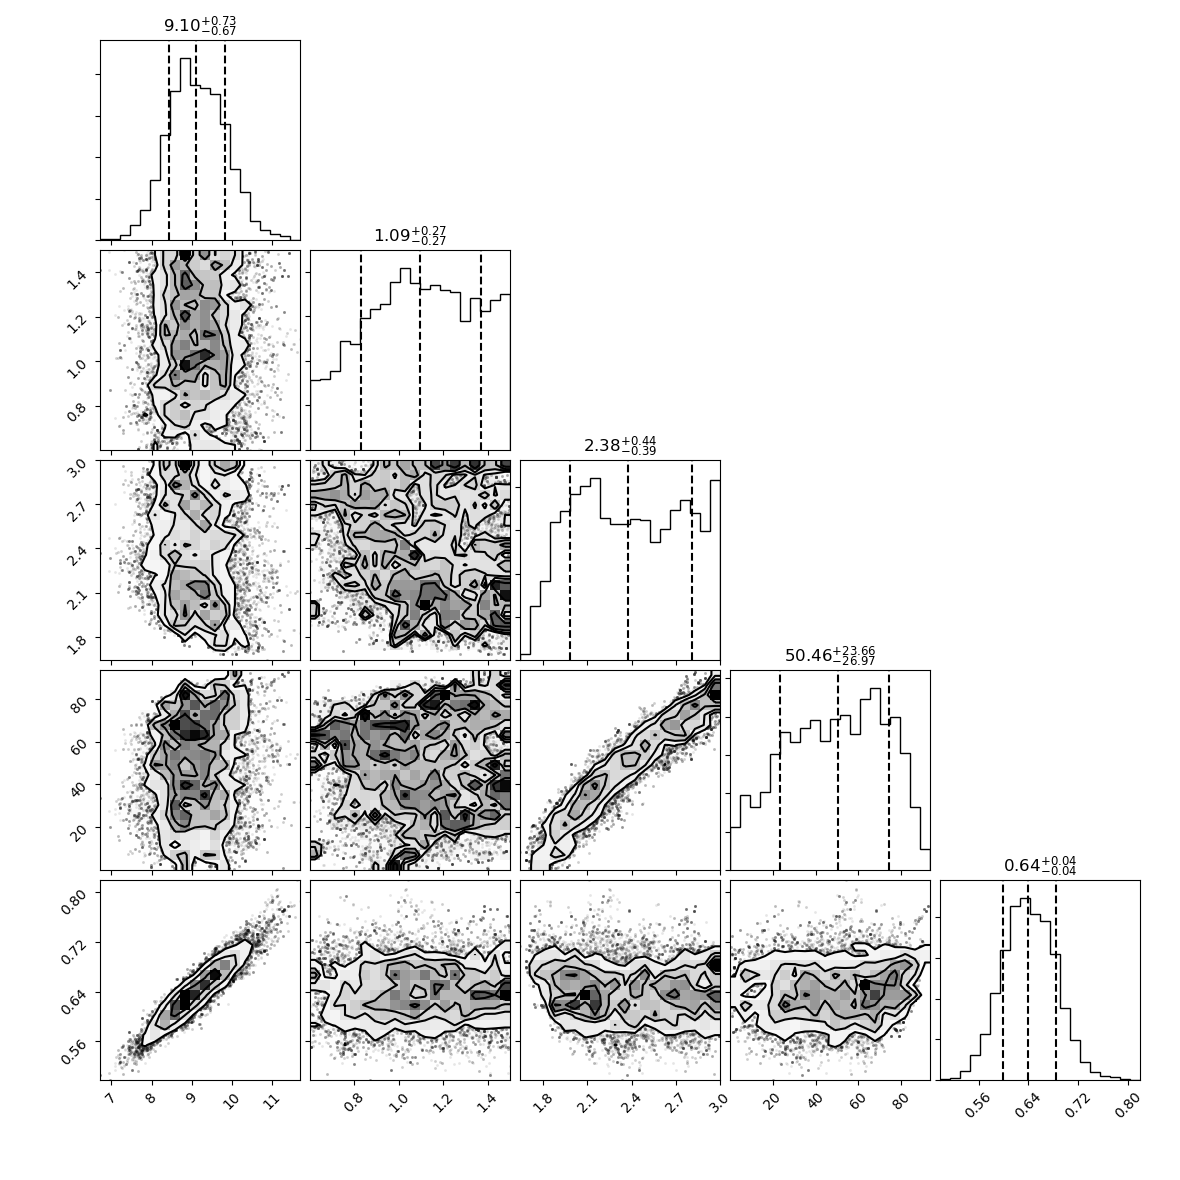

In [412]:
samples = sampler.get_chain(flat=True,discard=burnin)
tmp = samples.copy()
tmp[:,0] = np.exp(samples[:,0])/1e11
tmp[:,2] = np.exp(samples[:,2])/1e9
fig = corner.corner(tmp, quantiles=[.16,.50,.84], show_titles=True)

In [413]:
sampler.get_chain(flat=True)[np.argmax(sampler.get_log_prob(flat=True))]

array([27.5252831 ,  1.29546925, 21.74494123, 75.97629116,  0.6320447 ])

In [414]:
samples = sampler.get_chain(flat=True)[np.random.randint(nwalkers*burnin,nwalkers*(max_samples-1), 10)]
samples = np.vstack([samples, 
                     sampler.get_chain(flat=True)[np.argmax(sampler.get_log_prob(flat=True))]])
samples

array([[27.52777184,  1.26408216, 21.67256678, 68.07564265,  0.66673673],
       [27.66116723,  0.86403503, 21.70064568, 73.55951481,  0.70956744],
       [27.60787025,  0.9472904 , 21.29231265,  1.65997585,  0.66606304],
       [27.52729601,  0.7658176 , 21.75499951, 68.67365897,  0.6396989 ],
       [27.51667393,  1.08779271, 21.56475386, 46.31670163,  0.61573486],
       [27.54823416,  1.02845707, 21.66202854, 61.95484977,  0.62635318],
       [27.6385719 ,  0.73042453, 21.59057292, 50.10315204,  0.66235796],
       [27.47342336,  1.35730618, 21.79236948, 80.75965328,  0.62504061],
       [27.53880083,  1.14823754, 21.78951386, 79.32483062,  0.62554096],
       [27.63853052,  1.05655111, 21.40654687, 30.19666137,  0.66673497],
       [27.5252831 ,  1.29546925, 21.74494123, 75.97629116,  0.6320447 ]])

In [415]:
t_grid = np.linspace(.001,10,250)
a_grid = np.exp(samples[:,0])
m_grid = samples[:,1]
v_grid = np.exp(samples[:,2])
theta_grid = samples[:,3]

m_uvm2 = np.ndarray((len(t_grid), len(a_grid)))
m_uvw1 = np.ndarray((len(t_grid), len(a_grid)))
m_uvw2 = np.ndarray((len(t_grid), len(a_grid)))

m_g = np.ndarray((len(t_grid), len(a_grid)))
m_r = np.ndarray((len(t_grid), len(a_grid)))
m_i = np.ndarray((len(t_grid), len(a_grid)))

for a, m, v, theta in zip(a_grid, m_grid, v_grid, theta_grid):
    for t in t_grid:
        model = kasen.SNCompanionCollision(a=a, 
                                           M=m*const.M_sun.cgs.value, 
                                           v = v
                                          )
        mag_uvm2 = kasen.ObservedFlux(model, theta, uvm2, 
                                           t = t, redshift=z, mu=mu, 
                                           local_EBV=NGC_ebv, 
                                           galactic_EBV=MW_ebv, return_mag=True)
        mag_uvw1 = kasen.ObservedFlux(model, theta, uvw1, 
                                           t = t, redshift=z, mu=mu, 
                                           local_EBV=NGC_ebv, 
                                           galactic_EBV=MW_ebv, return_mag=True)
        mag_uvw2 = kasen.ObservedFlux(model, theta, uvw2, 
                                           t = t, redshift=z, mu=mu, 
                                           local_EBV=NGC_ebv, 
                                           galactic_EBV=MW_ebv, return_mag=True)
        mag_g = kasen.ObservedFlux(model, theta, g, 
                                           t = t, redshift=z, mu=mu, 
                                           local_EBV=NGC_ebv, 
                                           galactic_EBV=MW_ebv, return_mag=True)
        mag_r = kasen.ObservedFlux(model, theta, r, 
                                           t = t, redshift=z, mu=mu, 
                                           local_EBV=NGC_ebv, 
                                           galactic_EBV=MW_ebv, return_mag=True)
        mag_i = kasen.ObservedFlux(model, theta, i, 
                                           t = t, redshift=z, mu=mu, 
                                           local_EBV=NGC_ebv, 
                                           galactic_EBV=MW_ebv, return_mag=True)
        
        m_uvm2[t_grid == t, a_grid == a] = mag_uvm2
        m_uvw1[t_grid == t, a_grid == a] = mag_uvw1
        m_uvw2[t_grid == t, a_grid == a] = mag_uvw2
        m_g[t_grid == t, a_grid == a] = mag_g
        m_r[t_grid == t, a_grid == a] = mag_r
        m_i[t_grid == t, a_grid == a] = mag_i

In [416]:
color_dict = {1: 'MediumAquaMarine',
              2: 'Crimson', 
              3: 'Goldenrod', 
              "uvw2": "#D71DE5",
              "uvm2": "#008DCB",
              "uvw1": "#A4A4E3"}

mark_color_dict = {2: 'white',
                   1: 'MediumAquaMarine',
                   3: 'Goldenrod'}
sym_dict = {1: 'o',
            2: 'o',
            3: 'X'}
mec_dict = {2: 'Crimson',
            1: '0.5',
            3: '0.5'}
mew_dict = {2: 4,
            1: 0.5,
            3: 0.5}
filt_dict = {1:'g', 2:'r', 3:'i'}
zorder_dict = {3: 10,
               1: 5,
               2: 2}

<IPython.core.display.Javascript object>


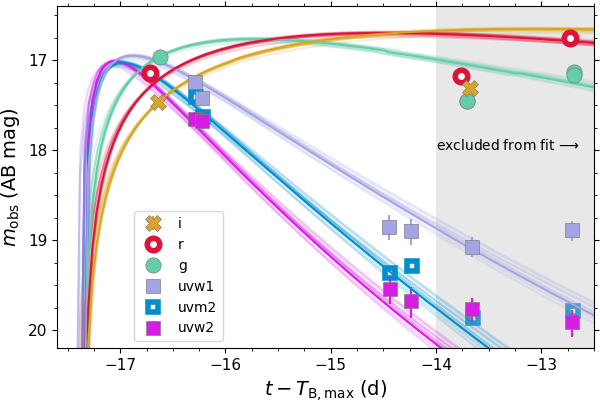

In [417]:
t_offset = (p48_df.mjd.values[0] - tbmax)/(1+z)


fig, ax = plt.subplots(figsize=(6,4))

# plot up models
for samp_num, t_exp in enumerate(samples[:,4]):
    model_offset = t_offset-t_exp
    alpha=0.2
    if samp_num == 10:
        alpha=1
    
    ax.plot(t_grid + model_offset, m_uvw2[:,samp_num], color_dict['uvw2'], alpha=alpha)
    ax.plot(t_grid + model_offset, m_uvm2[:,samp_num], color_dict['uvm2'], alpha=alpha)
    ax.plot(t_grid + model_offset, m_uvw1[:,samp_num], color_dict['uvw1'], alpha=alpha)
    ax.plot(t_grid + model_offset, m_g[:,samp_num], color_dict[1], alpha=alpha)
    ax.plot(t_grid + model_offset, m_r[:,samp_num], color_dict[2], alpha=alpha)
    ax.plot(t_grid + model_offset, m_i[:,samp_num], color_dict[3], alpha=alpha)


ax.errorbar(uvw2_time + t_fl, uvw2_mag, uvw2_mag_unc,
            fmt = 's', color=color_dict['uvw2'], 
            mec=mec_dict[1], mew=mew_dict[1], ms=10,
            label='uvw2')
ax.errorbar(uvm2_time + t_fl, uvm2_mag, uvm2_mag_unc,
            fmt = 's', color=mark_color_dict[2], 
            mec=color_dict['uvm2'], mew=mew_dict[2], ms=7,zorder=-1,
            label='uvm2')
ax.errorbar(uvw1_time + t_fl, uvw1_mag, uvw1_mag_unc,
            fmt = 's', color=color_dict['uvw1'], 
            mec=mec_dict[1], mew=mew_dict[1], ms=10, 
            label='uvw1')



# g-band
ax.errorbar((p48_df.mjd.iloc[g_obs].values - tbmax)/(1+z), 
            -2.5*np.log10(p48_df.flux.iloc[g_obs].values/3631), 
            2.5/np.log(10)*p48_df.flux_unc.iloc[g_obs].values/p48_df.flux.iloc[g_obs].values,
            fmt = sym_dict[1], color=mark_color_dict[1], ecolor=color_dict[1],
            mec=mec_dict[1], mew=mew_dict[1], ms=11,
            label = filt_dict[1], zorder = zorder_dict[1])

# r-band
ax.errorbar((p48_df.mjd.iloc[r_obs].values - tbmax)/(1+z), 
            -2.5*np.log10(p48_df.flux.iloc[r_obs].values/3631), 
            2.5/np.log(10)*p48_df.flux_unc.iloc[r_obs].values/p48_df.flux.iloc[r_obs].values,
            fmt = sym_dict[2], color=mark_color_dict[2], ecolor=color_dict[2],
            mec=mec_dict[2], mew=mew_dict[2], ms=9,
            label = filt_dict[2], zorder = zorder_dict[2])

# i-band
ax.errorbar((p48_df.mjd.iloc[i_obs].values - tbmax)/(1+z), 
            -2.5*np.log10(p48_df.flux.iloc[i_obs].values/3631), 
            2.5/np.log(10)*p48_df.flux_unc.iloc[i_obs].values/p48_df.flux.iloc[i_obs].values,
            fmt = sym_dict[3], color=mark_color_dict[3], ecolor=color_dict[3],
            mec=mec_dict[3], mew=mew_dict[3], ms=11,
            label = filt_dict[3], zorder = zorder_dict[3])



ax.set_ylim(20.2,16.4)
ax.set_xlim(-17.6,-12.5)
ax.set_xlabel(r'$t - T_\mathrm{B, max}\;(\mathrm{d})$', fontsize=14)
ax.set_ylabel(r'$m_\mathrm{obs}\;(\mathrm{AB\;mag})$', fontsize=14)
ax.xaxis.set_major_locator(MultipleLocator(1))
ax.xaxis.set_minor_locator(MultipleLocator(0.25))
ax.yaxis.set_major_locator(MultipleLocator(1))
ax.yaxis.set_minor_locator(MultipleLocator(0.25))
ax.tick_params(which='both', top=True,right=True, labelsize=11)

handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[::-1], labels[::-1], loc=3, fancybox=True, 
          bbox_to_anchor=(0.13,0.0))

ax.axvspan(-14, -2, facecolor='0.7', alpha=0.3)
ax.text(-14, 18, r'$\mathrm{excluded \; from \; fit}\, \longrightarrow$')

fig.subplots_adjust(left=0.095,bottom=0.13,top=0.985,right=0.99)
fig.savefig('../paper/figures/sn_companion_models.pdf')

In [300]:
lnlike_companion_collision((25.3, 1., 20.7, 20, 1),
                           t_rf, flux, flux_unc, filt,
                           redshift=z, mu=mu,
                           local_EBV=NGC_ebv, 
                           MW_EBV=MW_ebv)

-8141.686747197156

In [377]:
lnlike_companion_collision((27.52362594,  1.02862693, 21.70378767, 66.52293076,  0.63237063),
                           t_rf, flux, flux_unc, filt,
                           redshift=z, mu=mu,
                           local_EBV=NGC_ebv, 
                           MW_EBV=MW_ebv)

-13.05351562246464

In [401]:
lnlike_companion_collision((29.,  1.0, 21.70378767, 60.52293076,  0.83237063),
                           t_rf, flux, flux_unc, filt,
                           redshift=z, mu=mu,
                           local_EBV=0.25, 
                           MW_EBV=MW_ebv)

-1718.4489030157206